## 0 - Import Modules and Data

In [67]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV


import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC

from scipy.stats import zscore


import os
import joblib


# Plotting style
ftsize_title = 20
ftsize_axis = 16
sns.set_style('whitegrid')
sns.set_palette("viridis")

In [68]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

## 1 - Filter dataset

In [69]:
df_train.describe()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_LCSREC,DRNKANY6,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8,_FLSHOT7,_PNEUMO3,_AIDTST4,ID
count,225000.000000,225000.000000,2.250000e+05,225000.000000,225000.000000,225000.000000,225000.000000,2.250000e+05,2.250000e+05,48294.000000,...,26518.000000,225000.000000,2.249980e+05,225000.000000,2.250000e+05,225000.000000,85253.000000,85253.000000,200828.000000,225000.000000
mean,21.617533,6.743333,6.846816e+06,6.690351,15.444276,2022.050720,1121.452000,2.022005e+09,2.022005e+09,1.000021,...,1.899540,2.258800,1.121596e+02,2.074489,1.171380e+04,1.975716,2.400361,2.581962,2.017771,112499.500000
std,10.780828,3.526184,3.533200e+06,3.527551,8.526226,0.219426,41.048985,3.819732e+03,3.819732e+03,0.004550,...,0.300618,2.345706,2.747813e+02,2.555773,3.172859e+04,2.537339,2.728376,2.917661,1.648539,64952.049621
min,1.000000,1.000000,1.012023e+06,1.000000,0.000000,2022.000000,1100.000000,2.022000e+09,2.022000e+09,1.000000,...,1.000000,1.000000,5.397605e-79,1.000000,5.397605e-79,1.000000,1.000000,1.000000,1.000000,0.000000
25%,12.000000,4.000000,4.022022e+06,4.000000,8.000000,2022.000000,1100.000000,2.022002e+09,2.022002e+09,1.000000,...,2.000000,1.000000,5.397605e-79,1.000000,5.397605e-79,1.000000,1.000000,1.000000,1.000000,56249.750000
50%,23.000000,7.000000,7.112022e+06,7.000000,15.000000,2022.000000,1100.000000,2.022004e+09,2.022004e+09,1.000000,...,2.000000,2.000000,7.000000e+00,1.000000,4.700000e+01,1.000000,1.000000,1.000000,2.000000,112499.500000
75%,30.000000,10.000000,1.011202e+07,10.000000,22.000000,2022.000000,1100.000000,2.022007e+09,2.022007e+09,1.000000,...,2.000000,2.000000,4.300000e+01,1.000000,6.000000e+02,1.000000,2.000000,2.000000,2.000000,168749.250000
max,39.000000,12.000000,1.231202e+07,12.000000,31.000000,2023.000000,1200.000000,2.022018e+09,2.022018e+09,2.000000,...,2.000000,9.000000,9.000000e+02,9.000000,9.990000e+04,9.000000,9.000000,9.000000,9.000000,224999.000000


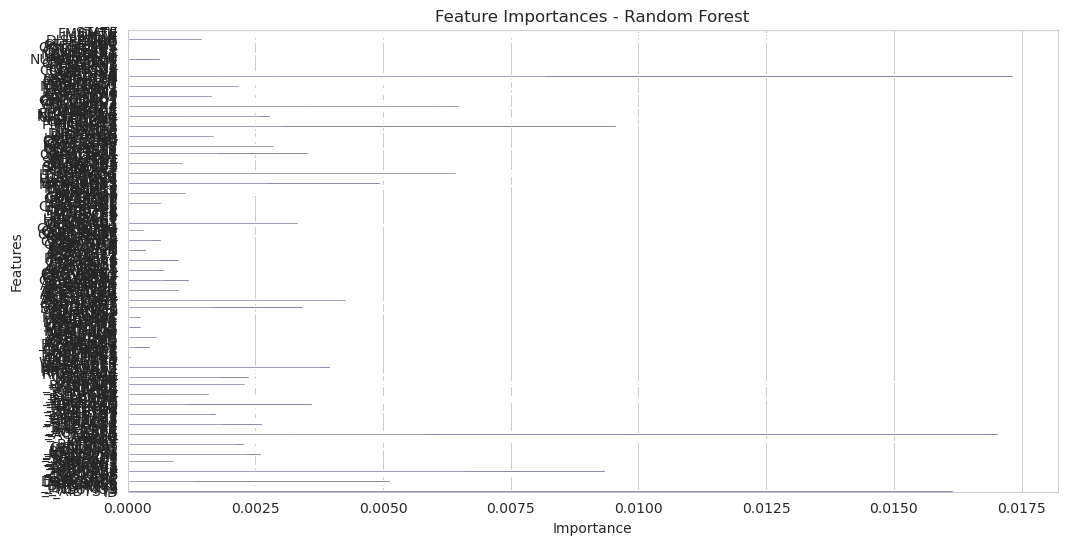

In [70]:
# feature importance using random forest
X = df_train.drop('TARGET', axis=1)
y = df_train['TARGET']

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_
feature_names = X.columns

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In [71]:
print(X.shape, y.shape)

(225000, 324) (225000,)


In [72]:
# remove all features with importance less than 0.005
important_features = feature_names[importances > 0.01]
print(important_features)
X_important = X[important_features]

# apply same changes to test set
X_test = df_test[important_features]

print(X_important.shape)

Index(['_STATE', 'IDATE', 'IDAY', 'SEQNO', '_PSU', 'GENHLTH', 'CVDSTRK3',
       'DIABAGE4', 'EMPLOY1', 'WEIGHT2', '_STSTR', '_STRWT', '_WT2RAKE',
       '_LLCPWT2', '_LLCPWT', '_RFHLTH', '_AGE80', 'HTIN4', 'HTM4', 'WTKG3',
       '_BMI5', 'ID'],
      dtype='object')
(225000, 22)


In [73]:
X_important.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225000 entries, 0 to 224999
Data columns (total 22 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _STATE    225000 non-null  float64
 1   IDATE     225000 non-null  int64  
 2   IDAY      225000 non-null  int64  
 3   SEQNO     225000 non-null  int64  
 4   _PSU      225000 non-null  float64
 5   GENHLTH   224999 non-null  float64
 6   CVDSTRK3  224999 non-null  float64
 7   DIABAGE4  30531 non-null   float64
 8   EMPLOY1   221762 non-null  float64
 9   WEIGHT2   216806 non-null  float64
 10  _STSTR    225000 non-null  float64
 11  _STRWT    225000 non-null  float64
 12  _WT2RAKE  225000 non-null  float64
 13  _LLCPWT2  225000 non-null  float64
 14  _LLCPWT   225000 non-null  float64
 15  _RFHLTH   225000 non-null  float64
 16  _AGE80    225000 non-null  float64
 17  HTIN4     208181 non-null  float64
 18  HTM4      210302 non-null  float64
 19  WTKG3     203594 non-null  float64
 20  _BMI

In [74]:
# print diabage4 feature importance
print(f"Diabage4 feature importance: {importances[feature_names.get_loc('DIABAGE4')]}")

# Remove diabage4 because too much nan values
X_important = X_important.drop('DIABAGE4', axis=1)
X_important.info()

# appluy same changes to test set
X_test = X_test.drop('DIABAGE4', axis=1)

Diabage4 feature importance: 0.01078210342386762
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225000 entries, 0 to 224999
Data columns (total 21 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _STATE    225000 non-null  float64
 1   IDATE     225000 non-null  int64  
 2   IDAY      225000 non-null  int64  
 3   SEQNO     225000 non-null  int64  
 4   _PSU      225000 non-null  float64
 5   GENHLTH   224999 non-null  float64
 6   CVDSTRK3  224999 non-null  float64
 7   EMPLOY1   221762 non-null  float64
 8   WEIGHT2   216806 non-null  float64
 9   _STSTR    225000 non-null  float64
 10  _STRWT    225000 non-null  float64
 11  _WT2RAKE  225000 non-null  float64
 12  _LLCPWT2  225000 non-null  float64
 13  _LLCPWT   225000 non-null  float64
 14  _RFHLTH   225000 non-null  float64
 15  _AGE80    225000 non-null  float64
 16  HTIN4     208181 non-null  float64
 17  HTM4      210302 non-null  float64
 18  WTKG3     203594 non-null  float64


Number of features without outliers: 14
Number of features with at least one outlier: 7
Number of rows without outliers: 213164
Number of rows with at least one outlier: 11836


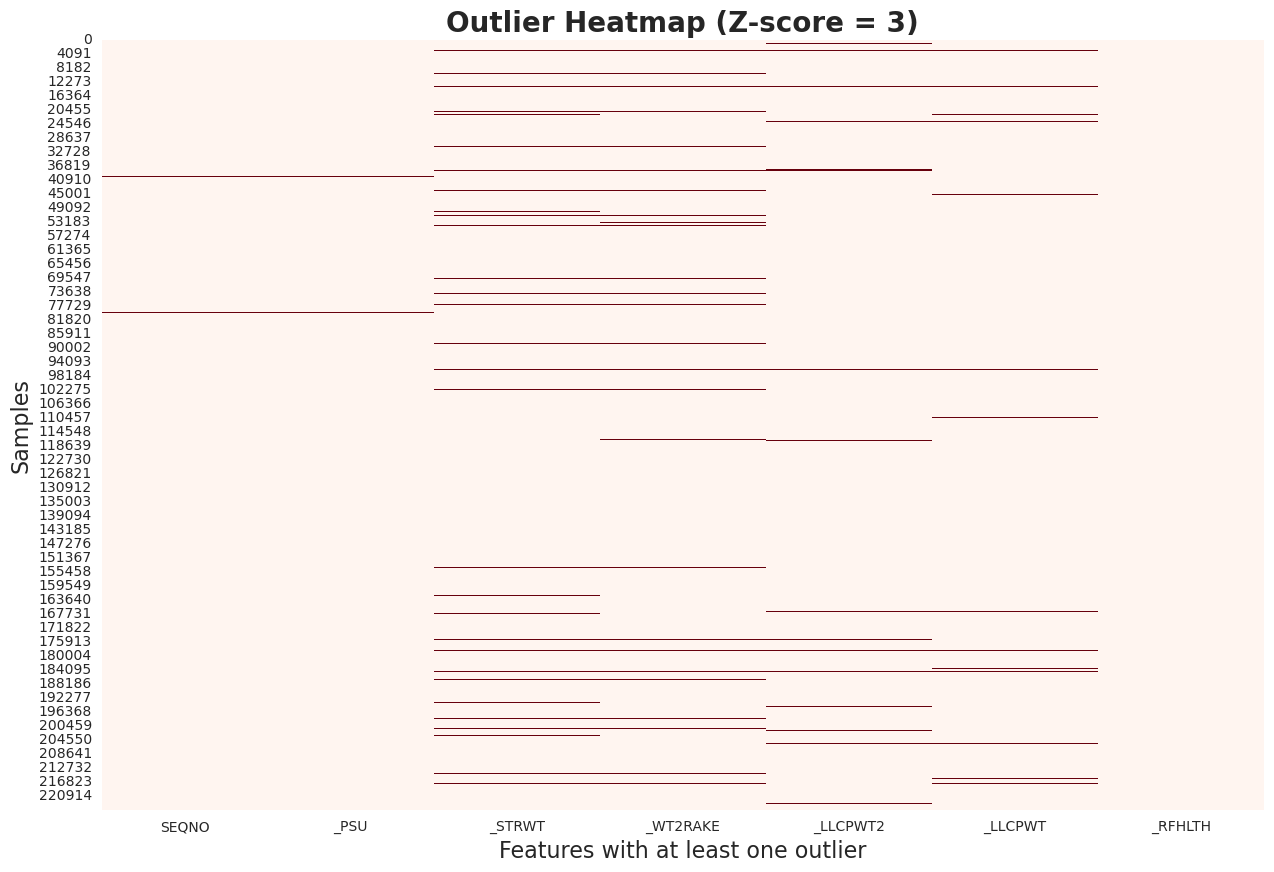

In [75]:
# Calculate Z-scores
z_scores = zscore(X_important)
z_scores_df = pd.DataFrame(z_scores, columns=X_important.columns)

# Define Z-score threshold
threshold = 3
outliers = (np.abs(z_scores_df) > threshold)

# Count the number of features with at least one outlier
nb_features_with_outliers = outliers.any(axis=0).sum()

# Count the number of features without any outliers
nb_features_without_outliers = (~outliers.any(axis=0)).sum()

# Print the results
print(f"Number of features without outliers: {nb_features_without_outliers}")
print(f"Number of features with at least one outlier: {nb_features_with_outliers}")

# Count the number of rows with at least one outlier
nb_rows_with_outliers = outliers.any(axis=1).sum()

# Count the number of rows without any outliers
nb_rows_without_outliers = (~outliers.any(axis=1)).sum()

# Print the results
print(f"Number of rows without outliers: {nb_rows_without_outliers}")
print(f"Number of rows with at least one outlier: {nb_rows_with_outliers}")

# Filter to include only features with at least one outlier
features_with_outliers = z_scores_df.loc[:, outliers.any(axis=0)]

# Plot a heatmap to visualize outliers
plt.figure(figsize=(15,10))
sns.heatmap(np.abs(features_with_outliers) > threshold, cbar=False, cmap='Reds')
plt.title(f'Outlier Heatmap (Z-score = {threshold})', fontsize=ftsize_title, fontweight='bold')
plt.xlabel('Features with at least one outlier', fontsize=ftsize_axis)
plt.ylabel('Samples', fontsize=ftsize_axis)
plt.show()

In [76]:
# remove all rows with at least one outlier
z_scores = zscore(X_important)
z_scores_df = pd.DataFrame(z_scores, columns=X_important.columns)
outliers = (np.abs(z_scores_df) > threshold)
rows_without_outliers = ~outliers.any(axis=1)
X_important = X_important[rows_without_outliers]
y = y[rows_without_outliers]


X_important.info()
y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 213164 entries, 0 to 224999
Data columns (total 21 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _STATE    213164 non-null  float64
 1   IDATE     213164 non-null  int64  
 2   IDAY      213164 non-null  int64  
 3   SEQNO     213164 non-null  int64  
 4   _PSU      213164 non-null  float64
 5   GENHLTH   213164 non-null  float64
 6   CVDSTRK3  213164 non-null  float64
 7   EMPLOY1   210110 non-null  float64
 8   WEIGHT2   205433 non-null  float64
 9   _STSTR    213164 non-null  float64
 10  _STRWT    213164 non-null  float64
 11  _WT2RAKE  213164 non-null  float64
 12  _LLCPWT2  213164 non-null  float64
 13  _LLCPWT   213164 non-null  float64
 14  _RFHLTH   213164 non-null  float64
 15  _AGE80    213164 non-null  float64
 16  HTIN4     197535 non-null  float64
 17  HTM4      199456 non-null  float64
 18  WTKG3     193010 non-null  float64
 19  _BMI5     189836 non-null  float64
 20  ID       

In [77]:
# remove rows down to non null rows of column BMI5
X_important = X_important[X_important['_BMI5'].notnull()]
y = y[X_important.index]

X_important.info()
y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 189836 entries, 0 to 224999
Data columns (total 21 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _STATE    189836 non-null  float64
 1   IDATE     189836 non-null  int64  
 2   IDAY      189836 non-null  int64  
 3   SEQNO     189836 non-null  int64  
 4   _PSU      189836 non-null  float64
 5   GENHLTH   189836 non-null  float64
 6   CVDSTRK3  189836 non-null  float64
 7   EMPLOY1   189835 non-null  float64
 8   WEIGHT2   189836 non-null  float64
 9   _STSTR    189836 non-null  float64
 10  _STRWT    189836 non-null  float64
 11  _WT2RAKE  189836 non-null  float64
 12  _LLCPWT2  189836 non-null  float64
 13  _LLCPWT   189836 non-null  float64
 14  _RFHLTH   189836 non-null  float64
 15  _AGE80    189836 non-null  float64
 16  HTIN4     188065 non-null  float64
 17  HTM4      189836 non-null  float64
 18  WTKG3     189836 non-null  float64
 19  _BMI5     189836 non-null  float64
 20  ID       

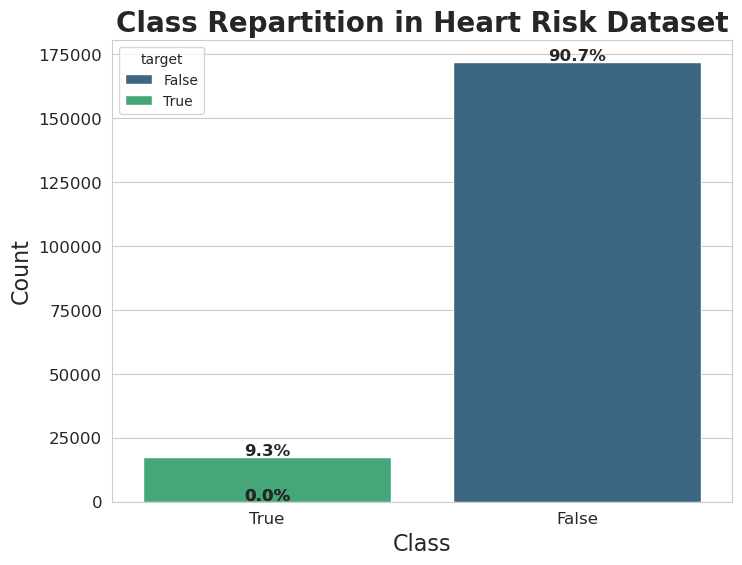

target
False    172169
True      17667
Name: count, dtype: int64


In [78]:
# Convert y to DataFrame
y_df = pd.DataFrame({'target': y})

# Plot class distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(
    x='target',
    data=y_df,
    palette='viridis',
    hue='target',
    dodge=False,
    order=y_df['target'].value_counts().sort_values().index
)

# Title and axis labels
plt.title('Class Repartition in Heart Risk Dataset', fontsize=ftsize_title, fontweight='bold')
plt.xlabel('Class', fontsize=ftsize_axis)
plt.ylabel('Count', fontsize=ftsize_axis)
plt.xticks(fontsize=ftsize_axis - 4)
plt.yticks(fontsize=ftsize_axis - 4)

# Annotate each bar with percentage
total = len(y_df)
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.1f}%'
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 500,
        percentage,
        ha='center',
        fontsize=ftsize_axis - 4,
        fontweight='bold'
    )

plt.show()

# Print class counts
print(y_df['target'].value_counts())

In [79]:
# Useful display function
def performance_display(y_test, y_pred, title):
    """Function that displays a beautiful confusion matrix

    Args:
        y_test (pd.DataFrame): True label values of testing set
        y_pred (pd.DataFrame): Predicted label values of testing set
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted', fontsize=ftsize_axis)
    plt.ylabel('Actual', fontsize=ftsize_axis)
    # Invert y axis
    plt.gca().invert_yaxis()
    title = 'Confusion Matrix - ' + title
    plt.title(title, fontsize=ftsize_title, fontweight='bold')
    plt.show()
    
    # Print classification report
    report = classification_report(y_true=y_test, y_pred=y_pred)
    print('Classification Report:')
    print(report)

## 2 - Train dataset

In [80]:
X_train, X_val, y_train, y_val = train_test_split(X_important, y, test_size=0.2, random_state=42, stratify=y)

Model loaded from models/rf_tuned.pkl


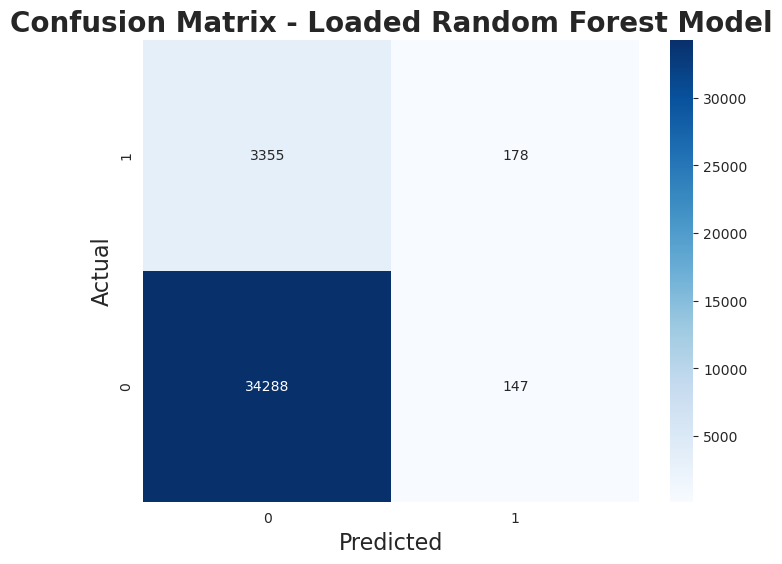

Classification Report:
              precision    recall  f1-score   support

       False       0.91      1.00      0.95     34435
        True       0.55      0.05      0.09      3533

    accuracy                           0.91     37968
   macro avg       0.73      0.52      0.52     37968
weighted avg       0.88      0.91      0.87     37968



In [81]:
choice = input("Do you want to train the Random Forest model or load it? (type 'train' or 'load'): ").strip().lower()
model_name = input("Enter Random Forest model filename to create or load (e.g., rf.pkl): ").strip()

model_path = os.path.join("models", model_name)


if choice == 'train':

    print("########### Training model ###########")

    # Define the parameter grid for Random Forest
    param_grid_rf = {
        # Number of trees in the forest. More trees = better generalization, but slower training.
        'n_estimators': [500],
        # 'n_estimators': [200],  
        # best : 500

        # Maximum depth of each tree. None means nodes are expanded until all leaves are pure. This impacts complexity and overfitting. 
        'max_depth': [None, 10, 30], 
        # best : None     
        
        # Minimum number of samples required to be at a leaf node. Higher values reduce overfitting.
        'min_samples_leaf': [1, 2, 4] 
        # best : 1
        }

    # Initialize the classifiers
    rf = RandomForestClassifier(random_state=42)

    # Initialize GridSearchCV for Random Forest
    grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=3, scoring='f1_macro')

    # Perform grid search for Random Forest
    grid_search_rf.fit(X_train, y_train)
    print("########### Training complete ###########")

    # Save or overwrite
    joblib.dump(value=grid_search_rf.best_estimator_, filename=model_path)
    print(f"Model saved to {model_path}\n")

    print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")
    print(f"Best score for Random Forest: {grid_search_rf.best_score_}")

    # Evaluate the best Random Forest model on the validation set
    best_rf = grid_search_rf.best_estimator_
    y_pred_rf = best_rf.predict(X_val)

    performance_display(y_val, y_pred_rf, "Random Forest")
    

elif choice == 'load':
    if os.path.exists(model_path):
        model = joblib.load(model_path)
        print(f"Model loaded from {model_path}")
        y_pred_rf = model.predict(X_val)
        performance_display(y_val, y_pred_rf, "Loaded Random Forest Model")
        
    else:
        print(f"No model found at {model_path}. Please train it first.")

else:
    print("Invalid choice. Please type 'train' or 'load'.")

In [82]:
# print X_test column ID
print(X_test.columns)
print(X_test['ID'])

Index(['_STATE', 'IDATE', 'IDAY', 'SEQNO', '_PSU', 'GENHLTH', 'CVDSTRK3',
       'EMPLOY1', 'WEIGHT2', '_STSTR', '_STRWT', '_WT2RAKE', '_LLCPWT2',
       '_LLCPWT', '_RFHLTH', '_AGE80', 'HTIN4', 'HTM4', 'WTKG3', '_BMI5',
       'ID'],
      dtype='object')
0        225000
1        225001
2        225002
3        225003
4        225004
          ...  
74995    299995
74996    299996
74997    299997
74998    299998
74999    299999
Name: ID, Length: 75000, dtype: int64


In [85]:
# output submission file
# convert this to a function

def create_submission_file(X_test, filename="submission", model_name="rf.pkl"):
    # Load trained model
    model = joblib.load(f"models/{model_name}")
    print(f"Model loaded from models/{model_name}")

    # Predict TARGET values
    y_pred = model.predict(X_test)

    # Create submission DataFrame
    submission_df = pd.DataFrame({
        "ID": X_test['ID'],
        "TARGET": y_pred.astype(bool)  # Convert to True/False
    })

    # Save to CSV
    filename = f"submissions/{filename}.csv"
    submission_df.to_csv(filename, index=False)
    print(f"Submission file saved as {filename}")

In [86]:
create_submission_file(X_test, filename="rf_tuned_submission", model_name="rf_tuned.pkl")

Model loaded from models/rf_tuned.pkl
Submission file saved as submissions/rf_tuned_submission.csv
